This notebook loads data including QQQ and has two modes to run. Generated data with ranks with different parameters so in the end it has multilvel index depending on the parameters  - lookback period X, lookback period Y and so on. then generated strategy based on different stocks (strategy is simple , just buy best x stocks) and final output is simulation and heatmap.

As for the second mode, it includes QQQ, strategy is changed to take consideration of QQQ. QQQ ranks are calcualted as other ranks, and if during the simulation, QQQ ranks is zero than either we don;t do anything until it gets better (positive again) or sell everythig, re buy other once it's get better.


Data is bi-weekly

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import vectorbt as vbt
from numba import njit
import plotly as plt
from vectorbt.portfolio import nb
import openpyxl
import quantstats as qs
from pandas_datareader import data as pdr
import yfinance as yfin
import glob
from csv import reader
import time

vbt.settings["caching"]["enabled"] = False
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.options.display.max_seq_items = 2000

In [2]:
#!pip install yfinance==0.2.58

In [3]:
dataset = "QQQ" #should be either "QQQ" or "SNP"
single_params = {"lookback_period":250, "roc_period": 250, "stocks":2}
# Vanilla stays with 1 stock, Correl gets 2 Stock, 250/250  is the best.
multi_params = {"min_lookback_period": 100, "max_lookback_period":300,
                "min_roc_period":100, "max_roc_period": 300,
               "step": 50, "min_stocks":5, "max_stocs": 5}

simulation_type = "single" #should be either "single" or "multi"
wild = False
update = True

In [4]:
data = None
qqq_rank = None

In [5]:
if update == True:
    # Data update
    #outdated...
    #yfin.pdr_override()
    # open file in read mode
    from1 = "2023-12-02"
    to = "2025-07-18"
    #Delete all
    fileList = glob.glob(r'/home/john/stocks/Data/QQQ/*.csv')
    
    for filePath in fileList:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

    if wild == True:
        paf = r'/home/john/stocks/Data/WILD.csv'
    else:
        paf = r'/home/john/stocks/Data/NASDAQ20231210.csv'
    
    #Download all
    with open(paf, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        downloads = {}
        t = 1
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            string = ''
            path = r'/home/john/stocks/Data/QQQ/'
            print(row)
            
            try:
                hist = yfin.download(string.join(row), from1, to)
                #time. sleep(3)
                #hist = web.DataReader(string.join(row), 'yahoo', from1, to)
            except:
                print("Not available with Yahoo: ",row)
    
            downloads[t] = len(hist)
            if downloads[t] == downloads[1]:
                hist.to_csv(path + string.join(row) + '.csv')
            else:
              print("Stock not the full time on exchange", str(row))
            t += 1

    #Download Benchmark
    
    row = "QQQ"
    string = ''
    path = '/home/john/stocks/Data/QQQ/'
    hist = yfin.download(string.join(row), from1, to)
    hist.to_csv(path + string.join(row) + '.csv')
    

['ADBE']
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['AMD']
['ABNB']


[*********************100%***********************]  1 of 1 completed


['GOOG']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['AMZN']
['AEP']


[*********************100%***********************]  1 of 1 completed


['AMGN']


[*********************100%***********************]  1 of 1 completed


['ADI']


[*********************100%***********************]  1 of 1 completed


['ANSS']


[*********************100%***********************]  1 of 1 completed


['AAPL']


[*********************100%***********************]  1 of 1 completed


['AMAT']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['APP']


['ARM']


[*********************100%***********************]  1 of 1 completed


['ASML']


[*********************100%***********************]  1 of 1 completed


['AZN']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['TEAM']
['ADSK']


[*********************100%***********************]  1 of 1 completed


['ADP']


[*********************100%***********************]  1 of 1 completed


['AXON']


[*********************100%***********************]  1 of 1 completed


['BKR']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['BIIB']
['BKNG']


[*********************100%***********************]  1 of 1 completed


['AVGO']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['CDNS']


[*********************100%***********************]  1 of 1 completed

['CDW']



[*********************100%***********************]  1 of 1 completed


['CHTR']
['CTAS']


[*********************100%***********************]  1 of 1 completed


['CSCO']


[*********************100%***********************]  1 of 1 completed


['CCEP']


[*********************100%***********************]  1 of 1 completed


['CTSH']


[*********************100%***********************]  1 of 1 completed


['CMCSA']


[*********************100%***********************]  1 of 1 completed


['CEG']


[*********************100%***********************]  1 of 1 completed


['CPRT']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['CSGP']
['COST']


[*********************100%***********************]  1 of 1 completed


['CRWD']


[*********************100%***********************]  1 of 1 completed


['CSX']


[*********************100%***********************]  1 of 1 completed


['DDOG']


[*********************100%***********************]  1 of 1 completed


['DXCM']


[*********************100%***********************]  1 of 1 completed


['FANG']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['DASH']


['EA']


[*********************100%***********************]  1 of 1 completed


['EXC']


[*********************100%***********************]  1 of 1 completed


['FAST']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['FTNT']
['GEHC']


[*********************100%***********************]  1 of 1 completed


['GILD']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['GFS']
['HON']


[*********************100%***********************]  1 of 1 completed


['IDXX']


[*********************100%***********************]  1 of 1 completed


['INTC']


[*********************100%***********************]  1 of 1 completed


['INTU']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['ISRG']
['KDP']


[*********************100%***********************]  1 of 1 completed


['KLAC']


[*********************100%***********************]  1 of 1 completed


['KHC']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['LRCX']
['LIN']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['LULU']
['MAR']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['MRVL']
['MELI']


[*********************100%***********************]  1 of 1 completed


['META']


[*********************100%***********************]  1 of 1 completed


['MCHP']


[*********************100%***********************]  1 of 1 completed


['MU']


[*********************100%***********************]  1 of 1 completed


['MSFT']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['MSTR']


['MDLZ']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['MDB']



[*********************100%***********************]  1 of 1 completed


['MNST']
['NFLX']


[*********************100%***********************]  1 of 1 completed


['NVDA']


[*********************100%***********************]  1 of 1 completed


['NXPI']


[*********************100%***********************]  1 of 1 completed


['ORLY']


[*********************100%***********************]  1 of 1 completed


['ODFL']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['ON']
['PCAR']


[*********************100%***********************]  1 of 1 completed


['PLTR']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['PANW']
['PAYX']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['PYPL']


[*********************100%***********************]  1 of 1 completed


['PDD']
['PEP']


[*********************100%***********************]  1 of 1 completed


['QCOM']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['REGN']
['ROP']


[*********************100%***********************]  1 of 1 completed


['ROST']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['SBUX']
['SNPS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['TMUS']


[*********************100%***********************]  1 of 1 completed


['TTWO']
['TSLA']


[*********************100%***********************]  1 of 1 completed


['TXN']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['TTD']
['VRSK']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['VRTX']
['WBD']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['WDAY']
['XEL']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['ZS']


[*********************100%***********************]  1 of 1 completed


In [6]:
if dataset == "QQQ":
    DIR = "/home/john/stocks/Data/QQQ/"

    def load_data(directory):
        files = os.listdir(directory)
        print(files)
        stock_series = []
        cur = None
        cur_keys = []

        def get_data(file):
            path = f"{directory}/{file}"    
            df = pd.read_csv(path)
            df = df.drop([0,1])
            df = df.rename(columns={"Price":"Date"})
            df = df.set_index("Date")
            df = df[["Close"]]
            return df


        for file in files:
            new_one = get_data(file)
            cur_keys.append(file.replace(".csv", ""))
            stock_series.append(new_one)
            
        
        data = pd.concat(stock_series, axis = 1, keys = cur_keys)     
        data.vbt.drop_levels(-1, inplace=True)    
        return data

    data = load_data(DIR)
    qqq_rank = data["QQQ"]
    data = data.drop(columns=["QQQ"])
    data.dropna(subset = data.columns, how = 'all', inplace = True)
elif dataset == "SNP":
    DIR = "/home/john/stocks/Data/snp500_cleaned/"
    def load_data(directory):
        files = os.listdir(directory)
        stock_series = []
        cur = None
        cur_keys = []
        def get_data(file):
            path = f"{directory}/{file}"    
            df = pd.read_csv(path)
            try:
                df = df.set_index("Date")
            except Exception as e:
                print(file)
            return df


        for file in files:
            new_one = get_data(file)
            cur_keys.append(file.replace(".csv", ""))
            stock_series.append(new_one)
        
        
        data = pd.concat(stock_series, axis = 1, keys = cur_keys)
        data.vbt.drop_levels(-1, inplace=True)
        
        return data

    data = load_data(DIR)
    ##Fill nans with either previous value or next value
    for col in data.columns:
        data[col] = data[col].ffill()
        data[col] = data[col].bfill()
    
    data.index = pd.to_datetime(data.index)
    
data = data.astype(float)
data = data[data.index > "2010-06-10"] #remove everything else
#data = data[data.index < "2023-09-02"]

['AMZN.csv', 'DXCM.csv', 'AEP.csv', 'AVGO.csv', 'HON.csv', 'APP.csv', 'CCEP.csv', 'CSX.csv', 'MAR.csv', 'ADBE.csv', 'QCOM.csv', 'CDW.csv', 'FAST.csv', 'ROST.csv', 'PDD.csv', 'MDB.csv', 'TEAM.csv', 'ADSK.csv', 'QQQ.csv', 'CEG.csv', 'FTNT.csv', 'CDNS.csv', 'PANW.csv', 'BIIB.csv', 'LIN.csv', 'VRTX.csv', 'EXC.csv', 'SBUX.csv', 'ISRG.csv', 'MCHP.csv', 'PEP.csv', 'ADI.csv', 'BKNG.csv', 'TSLA.csv', 'NFLX.csv', 'VRSK.csv', 'CHTR.csv', 'TMUS.csv', 'AMGN.csv', 'ON.csv', 'MNST.csv', 'AMD.csv', 'ASML.csv', 'DDOG.csv', 'MRVL.csv', 'TTWO.csv', 'NXPI.csv', 'KDP.csv', 'REGN.csv', 'ROP.csv', 'MSFT.csv', 'INTC.csv', 'KHC.csv', 'ANSS.csv', 'XEL.csv', 'TXN.csv', 'CMCSA.csv', 'PLTR.csv', 'CSCO.csv', 'LRCX.csv', 'CTAS.csv', 'GEHC.csv', 'IDXX.csv', 'ARM.csv', 'FANG.csv', 'MDLZ.csv', 'WBD.csv', 'GOOG.csv', 'SNPS.csv', 'PYPL.csv', 'ADP.csv', 'BKR.csv', 'LULU.csv', 'CRWD.csv', 'MSTR.csv', 'CSGP.csv', 'MELI.csv', 'ORLY.csv', 'EA.csv', 'META.csv', 'ABNB.csv', 'CTSH.csv', 'GFS.csv', 'ZS.csv', 'INTU.csv', 'NVDA.csv

In [7]:

data.shape

(405, 100)

In [8]:
def momentum(data, lookback_period, roc_period):
    
    shifted_values = np.zeros(data.shape)
    shifted_values[:shifted_values.shape[0] - roc_period, :] = data[roc_period:, :]
    
    roc = ((shifted_values - data) / data) * 100
    roc = roc[:roc.shape[0] - roc_period, :]
    roc = np.ceil(roc)
    const = np.full(roc.shape, 0)
    roc = np.maximum(const, roc)
    const = np.full(roc.shape, 1)
    roc = np.minimum(const, roc)
    
    
    xxx = np.vstack([np.arange(lookback_period), np.ones(lookback_period)]).T
    values = np.zeros((data.shape[0] - lookback_period, data.shape[1]))  
    correl = np.zeros((data.shape[0] - lookback_period, data.shape[1]))  
    sortino = np.zeros((data.shape[0] - lookback_period, data.shape[1]))

    def sortino_ratio(series, N):
        mean = np.mean(series, axis = 1) * N
        for i in range(series.shape[0]):
            row = series[i]
            std_neg = np.std(row) * np.sqrt(N)
            mean[i] = mean[i] / std_neg
        
        return mean 
    
    for i in range(data.shape[1]):
        cur_data = np.log(data[:, i])

        # Sortino Ratio
        # pct_change = np.zeros(data[:, i].shape)
        # pct_change[1:] = np.diff(data[:, i]) / data[:, i][:-1] * 100
        # print(data[:, i].shape, pct_change.shape)
        
        view = np.lib.stride_tricks.sliding_window_view(cur_data, (lookback_period,))[1:, :]
        lin_reg=(np.linalg.inv(xxx.T @ xxx) @ (xxx.T) @ view.T)
                
        # slope
        roll_mat = lin_reg[0]
        
        #intercept
        lin_reg_b = lin_reg[1]

        x = view
        
        line = [i for i in range(len(view[0]))]
        m = np.tile(roll_mat[:, np.newaxis], x.shape[1])
        n = np.tile(lin_reg_b[:, np.newaxis], x.shape[1])
        y = np.multiply(line,m) + n

        #correlation
        samples = x.shape[1]
        centered_x = x - np.mean(x, axis=1, keepdims=True)
        centered_y = y - np.mean(y, axis=1, keepdims=True)
        cov_xy = np.mean(centered_x * centered_y, axis=1)
        var_x = np.mean(centered_x**2, axis=1)
        var_y = np.mean(centered_y**2, axis=1)
        corrcoef_xy = cov_xy / (np.sqrt(var_x *var_y))
        
        correl[:,i] = corrcoef_xy
        values[:, i] = roll_mat
        
        # Sortino part 2
        # pct_change_view = np.lib.stride_tricks.sliding_window_view(pct_change, (lookback_period,))[1:, :]
        # temp = sortino_ratio(pct_change_view, lookback_period)
        # sortino[:, i] = temp
        
    values = 1 + values
    values = np.power(values, 252)

    if roc.shape[0] - values.shape[0] >= 0:
        new_shape = roc.shape[0] - values.shape[0]
        roc = roc[new_shape:, :]
    else:
        new_shape = values.shape[0] - roc.shape[0]
        values = values[new_shape:, :]
        correl = correl[new_shape:, :]
        sortino = sortino[new_shape:, :]

    # Final calculation  
    res = roc * values #* correl
    
    original = np.full((data.shape[0], data.shape[1]), np.nan)
    original[original.shape[0] - res.shape[0]:, :] = res
    return original


def bi_weekly(ranks, data):
    data.index = pd.to_datetime(data.index)
    monday_data = data[data.index.weekday == 0]
    bi_weekly_data = monday_data.iloc[::2, :]
    
    
    ranks.index = pd.to_datetime(ranks.index)
    monday_ranks = ranks[ranks.index.weekday == 0] ## 0 is Monday
    bi_weekly_ranks = monday_ranks.iloc[::2, :]
    return bi_weekly_ranks, bi_weekly_data
    

def strategy(ranks, stock_selected):
    ##For multi level index columns
    size = np.full(ranks.shape, fill_value=np.nan)
    np_ranks = ranks
    n_stocks = bi_weekly_data.shape[1]
    for i in range(0, np_ranks.shape[1] // n_stocks):
        cur_batch = np_ranks[:, i * n_stocks:(i + 1) * n_stocks]
        
        argsort_indices = np.argsort(cur_batch, axis = 1) ##sort across row to get the best 2 stocks
        max_indices = argsort_indices[:, -1 * stock_selected :]
                
        ##skip those where ranks are not known , so first lookback period entries
        last_row_with_nan = np.where(np.isnan(cur_batch))[0][-1]
        ##Generate size matrix, where share is 0.95 / number of stocks, among max amount number of stocks
        for row, entry in enumerate(max_indices):
            if row <= last_row_with_nan: continue
            prev = row - 1
            if prev == last_row_with_nan + 1:
                ##initial buy
                entry = [(i * n_stocks) + x for x in entry]
                size[row, entry] = 0.95 / stock_selected ##OPEN current ones
            elif prev > last_row_with_nan + 1:
                entry = [(i * n_stocks) + x for x in entry]
                
                prev_entries = max_indices[prev]
                prev_entries = [(i * n_stocks) + x for x in prev_entries]
                if prev_entries == entry:
                    continue

                size[row, prev_entries] = 0 ##CLOSE the previous ones

                size[row, entry] = 0.95 / stock_selected ##OPEN current ones
    
    return size

In [9]:
logging = True if simulation_type == "single" else False
@njit
def pre_segment_func_multi_nb(c, price, sizes_np):
    """Perform rebalancing at a timestamp."""

    for col in range(c.from_col, c.to_col):
        # Target percentage requires knowing the value of all assets in the group
        # Let's calculate this value using the current order price (remove this to use previous close)
        c.last_val_price[col] = nb.get_col_elem_nb(c, col, price)
        
    # Fill the size array
    size = sizes_np[c.i]
    # Sort by order value to first sell the current positions to release funds
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    nb.sort_call_seq_nb(c, size, 5, 0, order_value_out)
    
    # Forward size to order_func_nb
    return (size,)

@njit
def order_func_multi_nb(c, size, price):
#     print("here/")
    """Create an order. Gets only executed if the current segment is active."""
    return nb.order_nb(
        size=nb.get_elem_nb(c, size),
        price=nb.get_elem_nb(c, price),
        size_type = 5,
        direction = 0,
        fixed_fees = 7,
        log=logging,
    )

In [10]:
def change_data_like_weights(data, weights):
    temp = data.copy()
    repeats_n = weights.shape[1] // data.shape[1]
    mutli_index = weights.columns
    temp = temp.to_numpy()
    temp = np.tile(temp, repeats_n)
    assert temp.shape == weights.shape
    
    return pd.DataFrame(data = temp, index = data.index, columns = mutli_index)

In [11]:
indicator = vbt.IndicatorFactory(class_name = "momentum_indicator",
                            short_name = "momentum",
                            input_names=["data"],
                            param_names=["lookback_period","roc_period"],
                            output_names=["momentum"]
                             ).from_apply_func(
                                momentum,
                                lookback_period = single_params["lookback_period"],
                                roc_period = single_params["roc_period"]
                             )

strategy = vbt.IndicatorFactory(class_name = "momentum_indicator",
                                short_name = "strategy",
                                input_names=["ranks"],
                                param_names=["stocks"],
                                output_names=["weights"]
                                 ).from_apply_func(
                                    strategy,
                                    stocks = single_params["stocks"]
                                    
                                 )

In [12]:
res = indicator.run(data)

In [13]:
def generate_args():
    lookback_periods = []
    orcs = []
    
    for x in range(multi_params["min_lookback_period"], multi_params["max_lookback_period"] +1, multi_params["step"]):
        for y in range(multi_params["min_roc_period"], multi_params["max_roc_period"] + 1, multi_params["step"]):
            lookback_periods.append(x)
            orcs.append(y)
        
    return lookback_periods, orcs

In [14]:
if simulation_type == "single":
    ##Get ranks
    results = indicator.run(data)

    ##Get biwebi_weekly ranks
    bi_weekly_ranks, bi_weekly_data = bi_weekly(results.momentum, data)
    #del results
    ##Generate sizes
    strategy_res = strategy.run(bi_weekly_ranks)
    # Define rebalancing dates (= active segments)
    segment_mask = pd.Series(True, index=strategy_res.weights.index)
    price = bi_weekly_data  #actual prices
    group = True
    
else:
    lookback_periods, rocs = generate_args()
    results = indicator.run(data, lookback_periods, rocs)
    bi_weekly_ranks, bi_weekly_data = bi_weekly(results.momentum, data)
    del results
    strategy_res = strategy.run(bi_weekly_ranks, [i for i in range(multi_params["min_stocks"],
                                                                                multi_params["max_stocs"] +1)])
    price = change_data_like_weights(bi_weekly_data, strategy_res.weights)
    group = [0,1,2]

In [15]:
# Define rebalancing dates (= active segments)
segment_mask = pd.Series(True, index=strategy_res.weights.index)  
# Define and run the simulation

pf = vbt.Portfolio.from_order_func(
    price,
    order_func_multi_nb,
    vbt.Rep('price'),  # *args passed to order_func_nb
    pre_segment_func_nb=pre_segment_func_multi_nb,
    pre_segment_args=(
        vbt.Rep('price'),
        strategy_res.weights.to_numpy(),
        ),
    broadcast_named_args=dict(  # broadcast to a single shape
        price=price,
    ),
    group_by=group,
    segment_mask=segment_mask,
    init_cash = 10000000,
    freq="1W",
    cash_sharing=True # share cash within each split
)

In [16]:
if simulation_type == "single":
    print(pf.stats())
elif simulation_type == "multi":
    fig = pf.total_profit().vbt.heatmap(
        x_level='momentum_roc_period', y_level='momentum_lookback_period', slider_level="strategy_stocks", symmetric=True,
        trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='0.0')))
    fig.show()

Start                         2023-12-04 00:00:00
End                           2025-07-07 00:00:00
Period                          266 days 00:00:00
Start Value                            10000000.0
End Value                          12395442.70017
Total Return [%]                        23.954427
Benchmark Return [%]                    52.408954
Max Gross Exposure [%]                  96.147165
Total Fees Paid                              49.0
Max Drawdown [%]                        27.795807
Max Drawdown Duration            28 days 00:00:00
Total Trades                                    5
Total Closed Trades                             3
Total Open Trades                               2
Open Trade PnL                     2365386.333566
Win Rate [%]                            66.666667
Best Trade [%]                          67.087799
Worst Trade [%]                        -15.033343
Avg Winning Trade [%]                   36.665532
Avg Losing Trade [%]                   -15.033343


In [17]:
if simulation_type == "multi":
    pf.total_profit(group_by=False)
    plt.offline.plot(fig, filename='heatmap.html')
    pf[(1, 100, 100)].plot() ##cumulative returns

In [18]:
if simulation_type == "single":
    pf.orders.records_readable.to_csv("orders.csv")
    pf.logs.records.to_csv("logs.csv")

In [19]:
pf.stats(agg_func=None).to_excel("stats.xlsx")

In [20]:
if simulation_type == "single":
    pf.plot_drawdowns()
else:
    pf[(1, 200, 250)].plot_drawdowns()

In [21]:
pf.qs.html_report(output='/home/john/stocks/vectorBT_simulations/ts.html')
#pf.qs.full_report()

/home/john/stocks/vectorBT_simulations/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/home/john/stocks/vectorBT_simulations/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/home/john/stocks/vectorBT_simulations/.env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [22]:
if simulation_type == "single":
    holdings1 = pf.assets()[-1:]
    for col in holdings1.columns:
        if holdings1[col].max() > 0:
            column_header = col
            break
    print(holdings1[column_header])

Date
2025-07-07    17365.75
Name: APP, dtype: float64


In [23]:
pd.set_option('display.max_rows', 5000)
pd.options.display.max_seq_items = 5000

In [24]:
results.momentum.tail().sort_values(by = results.momentum.tail().index[-1], axis = 1, ascending = False)

,PLTR,APP,MSTR,AXON,NFLX,CRWD,DASH,TTWO,AVGO,ZS,FTNT,GILD,CEG,BKNG,CSCO,TSLA,WBD,TEAM,META,TMUS,MELI,CCEP,ORLY,MNST,FAST,EXC,PAYX,XEL,ADP,COST,VRSK,AMZN,CHTR,ISRG,PANW,ADSK,INTU,NVDA,AEP,BKR,MAR,CTAS,CDNS,HON,KLAC,MSFT,ANSS,LRCX,CSGP,CTSH,IDXX,SBUX,GOOG,LIN,EA,ADI,DDOG,PYPL,KDP,MDLZ,TXN,SNPS,MRVL,AMD,TTD,ODFL,CPRT,AAPL,ABNB,PCAR,AMAT,WDAY,GFS,AZN,INTC,LULU,PEP,CSX,ADBE,QCOM,CDW,ROST,PDD,MDB,BIIB,VRTX,MCHP,AMGN,FANG,ON,ASML,NXPI,REGN,ROP,DXCM,KHC,CMCSA,GEHC,ARM,MU
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-07-11,5.910027,5.034621,3.030994,2.339977,2.061152,1.909532,1.967533,1.737047,1.610534,1.583641,1.665782,1.610665,1.462921,1.462401,1.420280,1.415564,1.353340,1.369658,1.335457,1.360419,1.332254,1.298222,1.314758,1.298013,1.266143,1.281238,1.247238,1.232540,1.227715,1.207119,1.178551,1.164186,1.173577,1.158430,1.140088,1.142585,1.113262,1.100168,1.130337,1.136519,1.112767,1.119623,1.088595,1.092703,1.057952,1.066437,1.063499,0.000000,1.052101,1.063773,1.026852,1.065544,0.000000,1.014334,0.997901,0.960770,0.956141,0.985915,0.965118,0.957448,0.909118,0.000000,0.900489,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-14,5.898271,4.970174,3.020334,2.325513,2.062701,1.925706,1.962202,1.738686,1.619407,1.595996,1.654775,1.605779,1.469098,1.464925,1.419431,1.413305,1.354610,1.361136,1.336205,1.352780,1.332224,1.300115,1.312370,1.299165,1.266554,1.278505,1.242061,1.227993,1.222650,1.205034,1.179680,1.166769,1.172073,1.154227,1.139092,1.141287,1.117690,1.107323,1.128812,1.133151,1.113679,1.117614,1.094492,1.095467,1.067986,1.072563,1.067498,0.000000,1.054672,1.060706,1.032194,1.059936,0.000000,1.014223,0.998415,0.965551,0.960199,0.980788,0.963984,0.957790,0.913300,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-15,5.887113,4.908430,3.018034,2.313368,2.064597,1.942398,1.955670,1.740034,1.629237,1.608528,1.644645,1.600167,1.473593,1.467330,1.418167,1.410923,1.355898,1.351707,1.336208,1.345214,1.331929,1.300821,1.309321,1.299286,1.268021,1.275473,1.236926,1.222457,1.217607,1.202724,1.180284,1.169148,1.170553,1.149342,1.138648,1.139401,1.122535,1.115368,1.127083,1.130094,1.114219,1.114850,1.100461,1.097980,1.078521,1.078869,1.071785,0.000000,1.056833,1.057589,1.036805,1.053329,0.000000,1.013523,0.998795,0.969972,0.964845,0.975429,0.962512,0.957448,0.917298,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-16,5.876305,4.845110,3.019702,2.302579,2.065831,1.957809,1.949765,1.741634,1.638472,1.620635,1.633559,1.595159,1.475502,1.469805,1.416913,1.410184,1.360922,1.343383,1.335358,1.338233,1.331317,1.302466,1.306261,1.299606,1.270268,1.272467,1.232745,1.217623,1.213119,1.199965,1.181370,1.171142,1.168970,1.144512,1.138031,1.137608,1.127875,1.123070,1.125872,1.127252,1.115516,1.112549,1.105835,1.100991,1.089331,1.084917,1.075037,0.000000,1.059617,1.055126,1.041994,1.047665,-0.000000,1.013185,0.999547,0.974978,0.969544,0.970585,0.961361,0.957875,0.921651,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-17,5.864243,4.775161,3.016723,2.291408,2.067067,1.971324,1.941214,1.741060,1.645094,1.630894,1.622684,1.590541,1.473950,1.471214,1.416811,1.408053,1.367900,1.334367,1.332456,1.331090,1.328934,1.304248,1.303264,1.300266,1.273054,1.270263,1.229355,1.213694,1.209181,1.197109,1.182342,1.172433,1.167895,1.139102,1.137381,1.135644,1.133081,1.129136,1.125229,1.124642,1.115786,1.110975,1.109639,1.104368,1.097566,1.090932,1.077457,1.071165,1.061977,1.053222,1.046954,1.042031,1.

<Axes: xlabel='Date'>

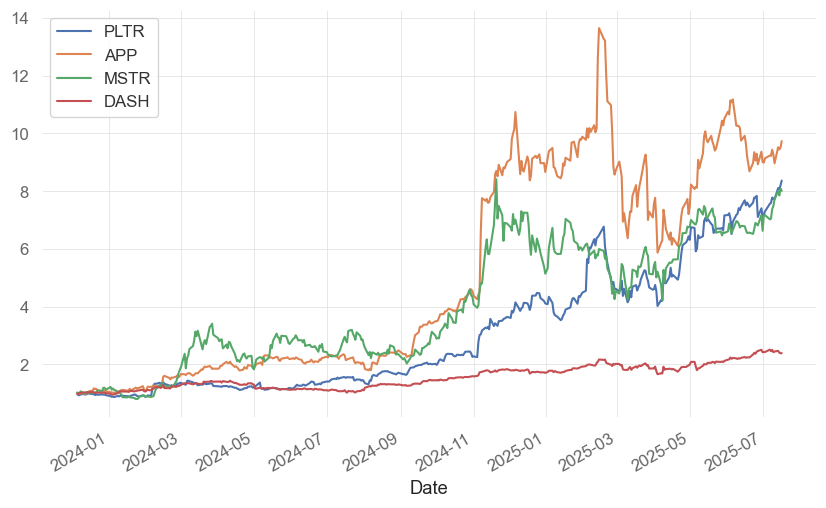

In [25]:
(data[["PLTR", "APP", "MSTR", "DASH"]].pct_change()+1).cumprod().plot()

In [26]:
type(results.momentum)

pandas.core.frame.DataFrame

In [27]:
top_five = results.momentum.iloc[-1].nlargest(5)

In [28]:
columns= top_five.index

In [29]:
results.momentum[columns].plot()pltr

SyntaxError: invalid syntax (1598538117.py, line 1)

In [ ]:
slope = pd.DataFrame(np.gradient(results.momentum, axis= 0), results.momentum.index, results.momentum.columns)

In [ ]:
slope[columns].plot()

In [ ]:
results.momentum.plot()

In [ ]:
#pf.assets()